In [1]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
import os
import numpy as np
from scipy.misc import imread, imresize
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from random import shuffle

import pandas as pd

import pickle

from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier,ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing

%matplotlib inline

In [3]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [4]:
ALL_DATA_DIR = '/home/datasets/emotions/'
INPUT_SIZE = (224, 224)
#INPUT_SIZE = (299, 299)

---

# AffectNet

In [5]:
AFFECT_DATA_DIR=ALL_DATA_DIR+'AffectNet/'
AFFECT_TRAIN_DATA_DIR = AFFECT_DATA_DIR+'full_res/train_all'
AFFECT_VAL_DATA_DIR = AFFECT_DATA_DIR+'full_res/val'
AFFECT_IMG_TRAIN_DATA_DIR = AFFECT_DATA_DIR+str(INPUT_SIZE[0])+'/train_all'
AFFECT_IMG_VAL_DATA_DIR = AFFECT_DATA_DIR+str(INPUT_SIZE[0])+'/val'
AFFECT_TRAIN_ORIG_DATA_DIR = AFFECT_DATA_DIR+'orig/train'
AFFECT_VAL_ORIG_DATA_DIR = AFFECT_DATA_DIR+'orig/val'

IMG_AFFECT_DATA_DIR = AFFECT_DATA_DIR+'Manually_Annotated_Images/'
AFFECT_TRAIN_FILE=AFFECT_DATA_DIR+'training.csv'
AFFECT_VAL_FILE=AFFECT_DATA_DIR+'validation.csv'

Index(['subDirectory_filePath', 'face_x', 'face_y', 'face_width',
       'face_height', 'facial_landmarks', 'expression', 'valence', 'arousal'],
      dtype='object')
689/737db2483489148d783ef278f43f486c0a97e140fc4b6b61b84363ca.jpg 134.0 134.0 899 899 1
392/c4db2f9b7e4b422d14b6e038f0cdc3ecee239b55326e9181ee4520f9.jpg 20.0 20.0 137 137 0
468/21772b68dc8c2a11678c8739eca33adb6ccc658600e4da2224080603.jpg 11.0 11.0 176 176 0
944/06e9ae8d3b240eb68fa60534783eacafce2def60a86042f9b7d59544.jpg 40.0 40.0 269 269 1
993/02e06ee5521958b4042dd73abb444220609d96f57b1689abbe87c024.jpg 22.0 22.0 153 153 8


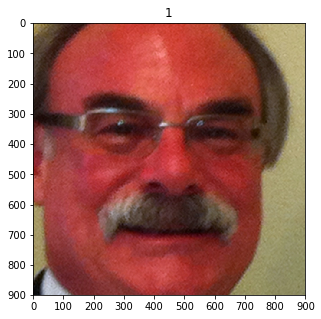

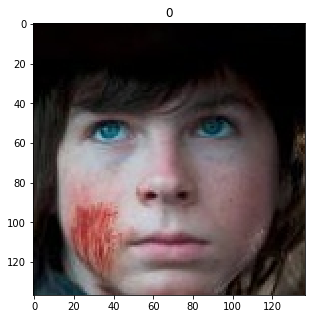

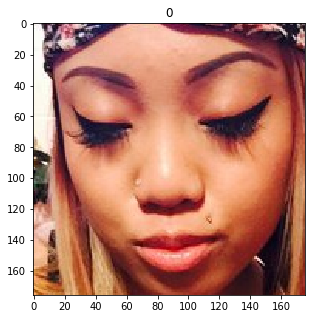

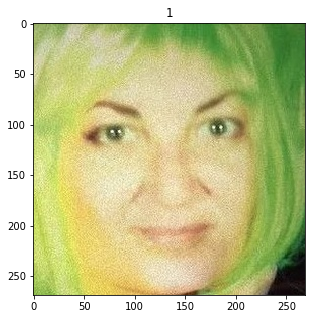

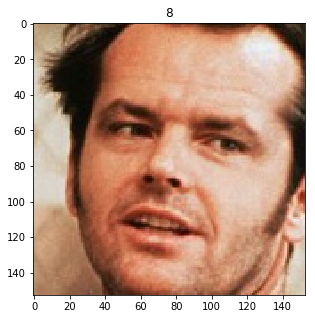

In [39]:
affect_df = pd.read_csv(AFFECT_TRAIN_FILE)
print(affect_df.columns)
#affect_df.head()

affect_df=affect_df.drop(columns=['facial_landmarks', 'valence', 'arousal'])
#affect_df.head()

for i,d in affect_df.iterrows():
    if i>=5:
        break
    print(d.subDirectory_filePath,d.face_x,d.face_y, d.face_width, d.face_height, d.expression)
    plt.figure(figsize=(5, 5))
    img=cv2.imread(os.path.join(IMG_AFFECT_DATA_DIR,d.subDirectory_filePath))
    x,y=int(d.face_x),int(d.face_y)
    w,h=int(d.face_width),int(d.face_height)
    img=img[y:y+h,x:x+w]
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    descr=str(d.expression)
    plt.title(descr)
plt.show()

In [8]:
express_np=affect_df.expression.values
print(express_np.min(),express_np.max())
print(np.histogram(express_np))

0 10
(array([ 74874, 134416,  25459,  14090,   6378,   3803,  24882,   3750,
        33088,  94060]), array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]))
2/9db2af5a1da8bd77355e8c6a655da519a899ecc42641bf254107bfc0.jpg nan nan -1 -1 1


In [215]:
emotion_labels=['Neutral','Happiness', 'Sadness', 'Surprise', 'Fear', 'Disgust', 'Anger', 'Contempt']
def save_images(filename,dir_to_save, same_size=-1, extractROI=True):
    affect_df = pd.read_csv(filename)
    affect_vals=[d for i,d in affect_df.iterrows()]
    for d in log_progress(affect_vals):
        #print(d.subDirectory_filePath,d.face_x,d.face_y, d.face_width, d.face_height, d.expression)
        if d.expression>=len(emotion_labels) or d.face_width<0:
            continue
        input_path=os.path.join(IMG_AFFECT_DATA_DIR,d.subDirectory_filePath)
        outdir_path=os.path.join(dir_to_save,emotion_labels[d.expression])
        if not os.path.exists(outdir_path):
            os.makedirs(outdir_path)
        dst_file_path=os.path.join(outdir_path,os.path.basename(d.subDirectory_filePath))
        #print(input_path,dst_file_path)
        if not os.path.exists(dst_file_path):
            if extractROI:
                img=cv2.imread(input_path)
                x,y=int(d.face_x),int(d.face_y)
                w,h=int(d.face_width),int(d.face_height)
                area=img[y:y+h,x:x+w]
                if same_size>0:
                    area = cv2.resize(area,(same_size,same_size))
                cv2.imwrite(dst_file_path,area)
            else:
                os.symlink(input_path,dst_file_path)
        else:
            print('duplicate, several faces?',d.subDirectory_filePath)

In [10]:
save_images(AFFECT_TRAIN_FILE,AFFECT_TRAIN_DATA_DIR)

In [44]:
save_images(AFFECT_VAL_FILE,AFFECT_VAL_DATA_DIR)

In [14]:
save_images(AFFECT_VAL_FILE,AFFECT_IMG_VAL_DATA_DIR,INPUT_SIZE[0])

In [15]:
save_images(AFFECT_TRAIN_FILE,AFFECT_IMG_TRAIN_DATA_DIR,INPUT_SIZE[0])

In [218]:
save_images(AFFECT_VAL_FILE,AFFECT_VAL_ORIG_DATA_DIR,-1, False)
save_images(AFFECT_TRAIN_FILE,AFFECT_TRAIN_ORIG_DATA_DIR,-1, False)

# Train

In [6]:
from keras.models import Model,Sequential, load_model,model_from_json
from keras.applications import mobilenet,mobilenet_v2,densenet,inception_resnet_v2,inception_v3,vgg16,resnet_v2,resnet
from keras.utils.generic_utils import CustomObjectScope
from keras.layers import Flatten, Dense, Dropout,GlobalAveragePooling2D,Activation, Conv2D, Reshape,DepthwiseConv2D,Input
from keras.optimizers import SGD, Adam
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, TensorBoard, Callback, CSVLogger, EarlyStopping
from keras.metrics import top_k_categorical_accuracy
import numpy as np
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
#from myimage import ImageDataGenerator

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

INPUT_SIZE = (224, 224)

BATCH_SIZE=40 #512 #64 #32 #64

def save_model(model,filename):
    model.save_weights('weights.h5')
    model_json = model.to_json()
    with open("model.json", "w") as json_file:
        json_file.write(model_json)

    json_file = open('model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights('weights.h5')
    loaded_model.save(filename)

Using TensorFlow backend.


In [7]:
USE_EFFICIENT_NET=False
USE_VGGFACE=False

if USE_EFFICIENT_NET:
    import efficientnet.keras as enet

    base_model = enet.EfficientNetB3(weights=None)
    base_model.load_weights('/home/avsavchenko/distr/efficientnet/efficientnet-b3-weights.h5')

    INPUT_SIZE = base_model.input_shape[1]
    INPUT_SIZE=(INPUT_SIZE,INPUT_SIZE)
    net_description='affectnet_enet3'
    net_model=enet
    BATCH_SIZE=16
    print(INPUT_SIZE)
elif USE_VGGFACE:
    import keras_vggface
    from keras_vggface import utils
    from keras_vggface.vggface import VGGFace
    from keras.preprocessing import image
    vgg_version=1
    if vgg_version==1:
        model_name, layer='vgg16','fc7/relu'
    else:
        model_name, layer='resnet50','flatten_1'
    base_model = VGGFace(model=model_name) # pooling: None, avg or max
    def vgg_preprocess_input(x,**kwargs):
        return utils.preprocess_input(x, version=vgg_version)
    preprocessing_function=vgg_preprocess_input
    base_model.summary()
    INPUT_SIZE = (224, 224)
    BATCH_SIZE=48
    net_description='vggface2'
elif False:
    net_model=mobilenet
    net_description='mobilenet_v1'
    INPUT_SIZE = (224, 224)
    BATCH_SIZE=80
    base_model = mobilenet.MobileNet(input_shape=(INPUT_SIZE[0],INPUT_SIZE[1],3), include_top=True, weights='imagenet')
elif False:
    net_model=inception_v3
    net_description='inception_v3'
    INPUT_SIZE = (299, 299)
    BATCH_SIZE=32
    base_model = inception_v3.InceptionV3(input_shape=(INPUT_SIZE[0],INPUT_SIZE[1],3), include_top=True, weights='imagenet')
else:
    base_model=load_model('age_gender_tf2_224_deep-03-0.13-0.97.h5')
    base_model.summary()
    net_description='my_mobilenet_7'
    if False:
        net_model=vgg16
    else:
        def mobilenet_preprocess_input(x,**kwargs):
            x[..., 0] -= 103.939
            x[..., 1] -= 116.779
            x[..., 2] -= 123.68
            return x
        preprocessing_function=mobilenet_preprocess_input
        
    BATCH_SIZE=80
    INPUT_SIZE = (224, 224)












Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         

/usr/local/lib/python3.5/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [8]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess=tf.Session(config=config)
set_session(sess)

In [9]:
if True:
    net_description='affectnet_'+net_description
    train_data_dir,val_data_dir=AFFECT_IMG_TRAIN_DATA_DIR,AFFECT_IMG_VAL_DATA_DIR
    #train_data_dir,val_data_dir=AFFECT_TRAIN_DATA_DIR,AFFECT_VAL_DATA_DIR
    #train_data_dir,val_data_dir=AFFECT_TRAIN_ORIG_DATA_DIR,AFFECT_VAL_ORIG_DATA_DIR
elif False:
    net_description='cufed_'+net_description
    train_data_dir=CUFED_TRAIN_DATA_DIR
    val_data_dir=CUFED_VAL_DATA_DIR
else:
    net_description='combined_filtered_'+net_description
    train_data_dir=COMBINED_TRAIN_DATA_DIR
    val_data_dir=COMBINED_VAL_DATA_DIR
    

print(train_data_dir,val_data_dir)
#net_description+='_imgnet'

/home/datasets/emotions/AffectNet/224/train_all /home/datasets/emotions/AffectNet/224/val


In [10]:
def random_crop(x, random_crop_size, sync_seed=None, **kwargs):
    np.random.seed(sync_seed)
    w, h = x.shape[1], x.shape[2]
    rangew = (w - random_crop_size[0]) // 2
    rangeh = (h - random_crop_size[1]) // 2
    offsetw = 0 if rangew == 0 else np.random.randint(rangew)
    offseth = 0 if rangeh == 0 else np.random.randint(rangeh)
    return x[:, offsetw:offsetw+random_crop_size[0], offseth:offseth+random_crop_size[1]]

if USE_VGGFACE:
    preprocessing_function=vgg_preprocess_input
elif True:
    pass
else:
    preprocessing_function=net_model.preprocess_input
target_size=INPUT_SIZE
#preprocessing_function,target_size=my_preprocessing,(256,256)
print(target_size)

(224, 224)


In [11]:
if True:
    train_datagen = ImageDataGenerator(featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False, 
                                   samplewise_std_normalization=False, zca_whitening=False, zca_epsilon=1e-06,
                                   rotation_range=0.1, width_shift_range=-0.1, height_shift_range=-0.1, brightness_range=None, shear_range=0.0, 
                                   zoom_range=0.1, channel_shift_range=1.05, fill_mode='nearest', horizontal_flip=True, vertical_flip=False,
                                   preprocessing_function=preprocessing_function)
else:
    train_datagen = ImageDataGenerator(preprocessing_function=preprocessing_function)

test_datagen = ImageDataGenerator(preprocessing_function=preprocessing_function)

tb = TensorBoard('logdir', write_graph=True, write_grads=True, write_images=True)


In [12]:
val_generator = test_datagen.flow_from_directory(
    val_data_dir, target_size=target_size,
    batch_size=BATCH_SIZE, class_mode='categorical',follow_links=True)

train_generator = train_datagen.flow_from_directory(
    train_data_dir, target_size=target_size,
    batch_size=BATCH_SIZE, class_mode='categorical',follow_links=True)

Found 3500 images belonging to 7 classes.
Found 283901 images belonging to 7 classes.


In [13]:
N_CLASS=val_generator.num_classes
nb_train_samples=train_generator.samples
nb_validation_samples=val_generator.samples
print(N_CLASS,nb_train_samples,nb_validation_samples)

class_to_idx=val_generator.class_indices
idx_to_class={class_to_idx[cls]:cls for cls in class_to_idx}
print(idx_to_class)

#np.save('idx_to_class.npy',np.array(idx_to_class))

7 283901 3500
{0: 'Anger', 1: 'Disgust', 2: 'Fear', 3: 'Happiness', 4: 'Neutral', 5: 'Sadness', 6: 'Surprise'}


In [14]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(train_generator.classes), 
                train_generator.classes)
print(class_weights)

print(class_weight.compute_class_weight(
               'balanced',
                np.unique(val_generator.classes), 
                val_generator.classes))

[ 1.62998496 10.66455054  6.35893473  0.30173184  0.54167382  1.59304316
  2.87844469]
[1. 1. 1. 1. 1. 1. 1.]


In [15]:
(unique, counts) = np.unique(train_generator.classes, return_counts=True)
cw=1/counts
cw/=cw.min()
class_weights = {i:cwi for i,cwi in zip(unique,cw)}
print(counts, class_weights, idx_to_class, val_generator.class_indices)

[ 24882   3803   6378 134415  74874  25459  14090] {0: 5.402097902097902, 1: 35.34446489613463, 2: 21.07478833490122, 3: 1.0, 4: 1.7952159628175335, 5: 5.279665344279037, 6: 9.539744499645138} {0: 'Anger', 1: 'Disgust', 2: 'Fear', 3: 'Happiness', 4: 'Neutral', 5: 'Sadness', 6: 'Surprise'} {'Fear': 2, 'Sadness': 5, 'Disgust': 1, 'Surprise': 6, 'Anger': 0, 'Happiness': 3, 'Neutral': 4}


In [19]:
#model,base_model=net()
if USE_EFFICIENT_NET:# or USE_VGGFACE:#  or True:
    x=base_model.layers[-2].output
else:
    layer_name='feats'
    #layer_name='global_average_pooling2d_1'
    #layer_name='fc7/relu'
    layer_out=base_model.get_layer(layer_name) #'global_pooling') #
    x=layer_out.output

emotion_preds = Dense(N_CLASS, activation='softmax', name='emotion_preds')(x)
model=Model(base_model.input,emotion_preds)
start_epoch=0

In [20]:
base_model.trainable=False
for l in base_model.layers:
    l.trainable=False
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
model.summary()

print(net_description)

mc = ModelCheckpoint(net_description+'.h5', monitor='val_acc', verbose=1, save_best_only=True)
es=EarlyStopping(monitor='val_acc',patience=2)
FIRST_EPOCHS=5
#tb, 
# Epoch 00005: val_acc improved from 0.19175 to 0.19500, saving model to my_mobilenet.h5

hist1=model.fit_generator(train_generator, steps_per_epoch=nb_train_samples//BATCH_SIZE, epochs=FIRST_EPOCHS, verbose=1, 
                    initial_epoch=0, callbacks=[mc, es], validation_data=val_generator, validation_steps=nb_validation_samples // BATCH_SIZE,class_weight=class_weights)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128 

3548/3548 [==============================] - 5390s 2s/step - loss: 6.0123 - acc: 0.3462 - val_loss: 1.7628 - val_acc: 0.3259

Epoch 00001: val_acc improved from -inf to 0.32587, saving model to my_mobilenet_7.h5
Epoch 2/5
3548/3548 [==============================] - 2377s 670ms/step - loss: 5.8520 - acc: 0.3602 - val_loss: 1.7516 - val_acc: 0.3316

Epoch 00002: val_acc improved from 0.32587 to 0.33158, saving model to my_mobilenet_7.h5
Epoch 3/5
3548/3548 [==============================] - 2381s 671ms/step - loss: 5.8343 - acc: 0.3571 - val_loss: 1.7547 - val_acc: 0.3146

Epoch 00003: val_acc did not improve from 0.33158
Epoch 4/5
3548/3548 [==============================] - 2380s 671ms/step - loss: 5.8316 - acc: 0.3565 - val_loss: 1.7440 - val_acc: 0.3301

Epoch 00004: val_acc did not improve from 0.33158


In [21]:
start_epoch=len(hist1.history['loss'])
for l in base_model.layers:
    l.trainable=True
    
model.load_weights(net_description+'.h5')
model.compile(optimizer=Adam(lr=1e-4,decay=1e-6), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
SECOND_EPOCHS=start_epoch+5
mc = ModelCheckpoint(net_description+'_ft.h5', monitor='val_acc', verbose=1, save_best_only=True)
#es=EarlyStopping(monitor='val_recall_1',patience=2 )

print('All tuning')
hist2=model.fit_generator(train_generator, steps_per_epoch=train_generator.samples//BATCH_SIZE, epochs=SECOND_EPOCHS, verbose=1, 
                    initial_epoch=start_epoch, validation_data=val_generator, validation_steps=val_generator.samples // BATCH_SIZE, callbacks=[mc],class_weight=class_weights)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128 

Epoch 5/9
3548/3548 [==============================] - 2433s 686ms/step - loss: 3.8674 - acc: 0.6434 - val_loss: 1.0403 - val_acc: 0.6142

Epoch 00005: val_acc improved from -inf to 0.61424, saving model to my_mobilenet_7_ft.h5
Epoch 6/9
3548/3548 [==============================] - 2445s 689ms/step - loss: 3.2932 - acc: 0.6914 - val_loss: 1.0158 - val_acc: 0.6272

Epoch 00006: val_acc improved from 0.61424 to 0.62719, saving model to my_mobilenet_7_ft.h5
Epoch 7/9
3548/3548 [==============================] - 2433s 686ms/step - loss: 3.0962 - acc: 0.7028 - val_loss: 0.9856 - val_acc: 0.6406

Epoch 00007: val_acc improved from 0.62719 to 0.64064, saving model to my_mobilenet_7_ft.h5
Epoch 8/9
3548/3548 [==============================] - 2418s 682ms/step - loss: 2.9770 - acc: 0.7094 - val_loss: 0.9883 - val_acc: 0.6418

Epoch 00008: val_acc improved from 0.64064 to 0.64181, saving model to my_mobilenet_7_ft.h5
Epoch 9/9
3548/3548 [==============================] - 2425s 683ms/step - loss:

all classes
orig
enet 3
Epoch 8/9
17978/17978 [==============================] - 9152s 509ms/step - loss: 0.5896 - acc: 0.7877 - val_loss: 1.5385 - val_acc: 0.5188

Epoch 00008: val_acc improved from 0.51425 to 0.51875, saving model to affectnet_enet3_ft.h5


cropped
mobilenet v1
Epoch 8/8
4494/4494 [==============================] - 1234s 275ms/step - loss: 0.4557 - acc: 0.8329 - val_loss: 1.5624 - val_acc: 0.5163

Epoch 00008: val_acc improved from 0.47485 to 0.51626, saving model to affectnet_mobilenet_v1_ft.h5


enet 0
Epoch 6/8
17978/17978 [==============================] - 4915s 273ms/step - loss: 0.3796 - acc: 0.8592 - val_loss: 2.1148 - val_acc: 0.5127
Epoch 00006: val_acc improved from 0.50010 to 0.51270, saving model to affectnet_enet0_ft.h5

inception 3
Epoch 7/8
8989/8989 [==============================] - 2693s 300ms/step - loss: 0.4970 - acc: 0.8178 - val_loss: 1.5130 - val_acc: 0.5310

Epoch 00007: val_acc improved from 0.49550 to 0.53100, saving model to inception_v3_ft.h5

enet 3
Epoch 8/8
17978/17978 [==============================] - 7612s 423ms/step - loss: 0.4615 - acc: 0.8312 - val_loss: 1.6691 - val_acc: 0.5190

Epoch 00008: val_acc improved from 0.51675 to 0.51900, saving model to affectnet_enet3_ft.h5


new class weights
mobilenet_v1
Epoch 3/5
3595/3595 [==============================] - 624s 173ms/step - loss: 6.0336 - acc: 0.4504 - val_loss: 2.4715 - val_acc: 0.2295

Epoch 00003: val_acc improved from 0.22625 to 0.22950, saving model to mobilenet_v1.h5
Epoch 8/10
3595/3595 [==============================] - 1359s 378ms/step - loss: 3.2450 - acc: 0.6539 - val_loss: 1.2269 - val_acc: 0.5687

Epoch 00008: val_acc improved from 0.55425 to 0.56875, saving model to mobilenet_v1_ft.h5
Anger 24882/500 acc: 52.400000
Contempt 3750/500 acc: 50.200000
Disgust 3803/500 acc: 47.400000
Fear 6378/500 acc: 52.800000
Happiness 134415/500 acc: 73.600000
Neutral 74874/500 acc: 63.200000
Sadness 25459/500 acc: 58.800000
Surprise 14090/500 acc: 56.000000


inception
Epoch 5/8
8989/8989 [==============================] - 4176s 465ms/step - loss: 3.9284 - acc: 0.6189 - val_loss: 1.1059 - val_acc: 0.5965

Epoch 00005: val_acc improved from 0.56925 to 0.59650, saving model to affectnet_inception_v3_ft.h5
Anger 24882/500 acc: 66.400000
Contempt 3750/500 acc: 51.400000
Disgust 3803/500 acc: 42.600000
Fear 6378/500 acc: 58.800000
Happiness 134415/500 acc: 77.200000
Neutral 74874/500 acc: 53.000000
Sadness 25459/500 acc: 60.800000
Surprise 14090/500 acc: 51.000000


enet3
17978/17978 [==============================] - 5533s 308ms/step - loss: 7.2364 - acc: 0.3030 - val_loss: 2.4867 - val_acc: 0.1713

Epoch 00001: val_acc improved from -inf to 0.17125, saving model to affectnet_affectnet_enet3.h5
Epoch 00006: val_acc improved from 0.59025 to 0.60275, saving model to affectnet_affectnet_enet3_ft.h5
Epoch 7/8
17978/17978 [==============================] - 7970s 443ms/step - loss: 2.9875 - acc: 0.6705 - val_loss: 1.1917 - val_acc: 0.6068

Anger 24882/500 acc: 49.000000
Contempt 3750/500 acc: 42.800000
Disgust 3803/500 acc: 51.400000
Fear 6378/500 acc: 65.200000
Happiness 134415/500 acc: 79.800000
Neutral 74874/500 acc: 63.600000
Sadness 25459/500 acc: 71.800000
Surprise 14090/500 acc: 56.400000

vggface
Epoch 8/9
5992/5992 [==============================] - 2540s 424ms/step - loss: 4.0993 - acc: 0.5805 - val_loss: 1.2613 - val_acc: 0.5478

Epoch 00008: val_acc improved from 0.53087 to 0.54782, saving model to affectnet_vggface1_ft.h5
Anger 24882/500 acc: 46.000000
Contempt 3750/500 acc: 49.400000
Disgust 3803/500 acc: 51.400000
Fear 6378/500 acc: 56.600000
Happiness 134415/500 acc: 71.800000
Neutral 74874/500 acc: 59.800000
Sadness 25459/500 acc: 56.600000
Surprise 14090/500 acc: 50.800000

vggface2
Epoch 2/5
5992/5992 [==============================] - 2445s 408ms/step - loss: 8.2640 - acc: 0.4664 - val_loss: 2.7049 - val_acc: 0.4087

Epoch 00002: val_acc improved from 0.40788 to 0.40865, saving model to vggface2.h5

Epoch 9/9
5992/5992 [==============================] - 2299s 384ms/step - loss: 2.8767 - acc: 0.6706 - val_loss: 1.2352 - val_acc: 0.5701

Epoch 00009: val_acc improved from 0.56503 to 0.57009, saving model to vggface2_ft.h5
Anger 24882/500 acc: 58.200000
Contempt 3750/500 acc: 51.600000
Disgust 3803/500 acc: 51.600000
Fear 6378/500 acc: 49.000000
Happiness 134415/500 acc: 81.000000
Neutral 74874/500 acc: 42.600000
Sadness 25459/500 acc: 55.400000
Surprise 14090/500 acc: 67.400000


my_mobilenet
vgg16 preprocessing
Epoch 3/5
3595/3595 [==============================] - 588s 164ms/step - loss: 7.0706 - acc: 0.3017 - val_loss: 1.8836 - val_acc: 0.2913

Epoch 00003: val_acc improved from 0.28725 to 0.29125, saving model to affectnet_my_mobilenet.h5

Epoch 9/10
3595/3595 [==============================] - 1200s 334ms/step - loss: 3.2316 - acc: 0.6474 - val_loss: 1.1412 - val_acc: 0.6040

Epoch 00009: val_acc improved from 0.60150 to 0.60400, saving model to affectnet_my_mobilenet_ft.h5
Epoch 11/12
3595/3595 [==============================] - 1332s 370ms/step - loss: 2.6827 - acc: 0.6834 - val_loss: 1.2303 - val_acc: 0.6030

Epoch 00011: val_acc improved from -inf to 0.60300, saving model to affectnet_my_mobilenet_ft_sgd.h5
Anger 24882/500 acc: 61.000000
Contempt 3750/500 acc: 61.600000
Disgust 3803/500 acc: 54.800000
Fear 6378/500 acc: 58.200000
Happiness 134415/500 acc: 70.200000
Neutral 74874/500 acc: 52.800000
Sadness 25459/500 acc: 62.400000
Surprise 14090/500 acc: 62.200000

Epoch 2/5
3595/3595 [==============================] - 592s 165ms/step - loss: 7.0776 - acc: 0.2994 - val_loss: 1.8758 - val_acc: 0.2948

Epoch 00002: val_acc improved from 0.27875 to 0.29475, saving model to my_mobilenet_new1.h5




other preprocessing
Epoch 4/5
3595/3595 [==============================] - 568s 158ms/step - loss: 7.0638 - acc: 0.2954 - val_loss: 1.8776 - val_acc: 0.2958

Epoch 00004: val_acc improved from 0.29125 to 0.29575, saving model to affectnet_my_mobilenet_new.h5
Epoch 8/10
3595/3595 [==============================] - 1224s 340ms/step - loss: 3.5965 - acc: 0.6256 - val_loss: 1.1440 - val_acc: 0.5970

Epoch 00008: val_acc improved from 0.58950 to 0.59700, saving model to affectnet_my_mobilenet_new_ft.h5
Epoch 12/12
3595/3595 [==============================] - 1265s 352ms/step - loss: 2.9799 - acc: 0.6626 - val_loss: 1.1828 - val_acc: 0.5990

Epoch 00012: val_acc improved from 0.59500 to 0.59900, saving model to affectnet_my_mobilenet_new_ft_sgd.h5
Anger 24882/500 acc: 57.400000
Contempt 3750/500 acc: 48.400000
Disgust 3803/500 acc: 53.600000
Fear 6378/500 acc: 62.600000
Happiness 134415/500 acc: 75.600000
Neutral 74874/500 acc: 57.200000
Sadness 25459/500 acc: 62.800000
Surprise 14090/500 acc: 60.600000

mymobilenet_ft_sgd_model.h5
Epoch 12/12
3595/3595 [==============================] - 4006s 1s/step - loss: 2.9808 - acc: 0.6615 - val_loss: 1.1678 - val_acc: 0.6043

Epoch 00012: val_acc improved from 0.60250 to 0.60425, saving model to my_mobilenet_new1_ft_sgd.h5

60.25
Anger 24882/500 acc: 61.800000
Contempt 3750/500 acc: 52.800000
Disgust 3803/500 acc: 55.000000
Fear 6378/500 acc: 64.000000
Happiness 134415/500 acc: 74.200000
Neutral 74874/500 acc: 53.400000
Sadness 25459/500 acc: 60.600000
Surprise 14090/500 acc: 60.200000



-Contempt
mobilenet v1
Epoch 5/8
4435/4435 [==============================] - 1235s 279ms/step - loss: 0.2484 - acc: 0.9080 - val_loss: 1.8529 - val_acc: 0.5602

Epoch 00005: val_acc improved from 0.54109 to 0.56024, saving model to affectnet_mobilenet_v1_ft.h5
Anger 24882/500 acc: 56.400000
Disgust 3803/500 acc: 34.000000
Fear 6378/500 acc: 48.600000
Happiness 134415/500 acc: 93.800000
Neutral 74874/500 acc: 69.600000
Sadness 25459/500 acc: 54.200000
Surprise 14090/500 acc: 33.600000


enet 0
Epoch 7/8
17743/17743 [==============================] - 2499s 141ms/step - loss: 0.4999 - acc: 0.8127 - val_loss: 1.2771 - val_acc: 0.5755

Epoch 00007: val_acc improved from 0.57520 to 0.57549, saving model to affectnet_enet0_ft.h5

Anger 24882/500 acc: 55.800000
Disgust 3803/500 acc: 31.200000
Fear 6378/500 acc: 44.200000
Happiness 134415/500 acc: 94.600000
Neutral 74874/500 acc: 75.200000
Sadness 25459/500 acc: 60.200000
Surprise 14090/500 acc: 43.400000

enet 3
Epoch 8/8
17743/17743 [==============================] - 7390s 416ms/step - loss: 0.4172 - acc: 0.8423 - val_loss: 1.3758 - val_acc: 0.5907

Epoch 00008: val_acc improved from 0.58984 to 0.59070, saving model to affectnet_affectnet_enet3_ft.h5

Epoch 12/13
17743/17743 [==============================] - 7543s 425ms/step - loss: 0.2991 - acc: 0.8890 - val_loss: 1.5174 - val_acc: 0.5941

Epoch 00012: val_acc improved from 0.59088 to 0.59414, saving model to affectnet_enet3_ft_sgd.h5
Anger 24882/500 acc: 59.800000
Disgust 3803/500 acc: 33.400000
Fear 6378/500 acc: 47.200000
Happiness 134415/500 acc: 94.000000
Neutral 74874/500 acc: 76.200000
Sadness 25459/500 acc: 59.400000
Surprise 14090/500 acc: 44.000000

inception
Epoch 5/5
8871/8871 [==============================] - 2776s 313ms/step - loss: 0.3805 - acc: 0.8551 - val_loss: 1.3908 - val_acc: 0.5882

Epoch 00005: val_acc improved from 0.58304 to 0.58824, saving model to affectnet_inception_v3_ft.h5

Anger 24882/500 acc: 61.200000
Disgust 3803/500 acc: 31.400000
Fear 6378/500 acc: 43.400000
Happiness 134415/500 acc: 92.600000
Neutral 74874/500 acc: 76.600000
Sadness 25459/500 acc: 59.600000
Surprise 14090/500 acc: 45.400000

vggface2
Epoch 00008: val_acc improved from 0.55046 to 0.56142, saving model to affectnet_vggface2_ft.h5


new class weights
my mobilenet
Epoch 10/11
3548/3548 [==============================] - 2425s 683ms/step - loss: 2.7805 - acc: 0.7204 - val_loss: 0.9717 - val_acc: 0.6480

Epoch 00010: val_acc improved from -inf to 0.64797, saving model to my_mobilenet_7_ft_sgd.h5

Anger 24882/500 acc: 56.400000
Disgust 3803/500 acc: 60.400000
Fear 6378/500 acc: 71.000000
Happiness 134415/500 acc: 87.000000
Neutral 74874/500 acc: 62.000000
Sadness 25459/500 acc: 63.400000
Surprise 14090/500 acc: 52.800000

In [22]:
model.load_weights(net_description+'_ft.h5')
model.compile(optimizer=SGD(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
#model.summary()
mc = ModelCheckpoint(net_description+'_ft_sgd.h5', monitor='val_acc', verbose=1, save_best_only=True)
second_epoch=start_epoch+len(hist2.history['loss'])
THIRD_EPOCHS=2+second_epoch

print('ALL SGD tuning')
hist3=model.fit_generator(train_generator, steps_per_epoch=train_generator.samples//BATCH_SIZE, epochs=THIRD_EPOCHS, verbose=1, 
                    initial_epoch=second_epoch, validation_data=val_generator, validation_steps=val_generator.samples // BATCH_SIZE,callbacks=[mc],class_weight=class_weights)

ALL SGD tuning
Epoch 10/11
3548/3548 [==============================] - 2425s 683ms/step - loss: 2.7805 - acc: 0.7204 - val_loss: 0.9717 - val_acc: 0.6480

Epoch 00010: val_acc improved from -inf to 0.64797, saving model to my_mobilenet_7_ft_sgd.h5
Epoch 11/11
3548/3548 [==============================] - 2426s 684ms/step - loss: 2.7304 - acc: 0.7227 - val_loss: 0.9748 - val_acc: 0.6480

Epoch 00011: val_acc did not improve from 0.64797


In [16]:
if False:
    #save_model(model,'mymobilenet_ft_sgd_model.h5')
    save_model(model,'mymobilenet_7_ft_sgd_model.h5')
else:
    model=load_model('mymobilenet_7_ft_sgd_model.h5')

/usr/local/lib/python3.5/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [17]:
y_val=np.array(val_generator.labels)
y_scores_val=[]
#model.load_weights(net_description+'_ft.h5')
for filepath in log_progress(val_generator.filepaths):
    img=cv2.imread(filepath)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img=cv2.resize(img,INPUT_SIZE)
    if True:
        inp = preprocessing_function(np.expand_dims(img, axis=0).astype(np.float32))
    else:
        inp=img.astype(np.float32)
        inp[..., 0] -= 103.939
        inp[..., 1] -= 116.779
        inp[..., 2] -= 123.68
        inp = np.expand_dims(inp, axis=0)

    scores=model.predict(inp)
    #print(scores.shape)
    y_scores_val.append(scores)

y_scores_val=np.concatenate(y_scores_val, axis=0)
print(y_scores_val.shape,y_val.shape)

(3500, 7) (3500,)


In [18]:
y_pred=np.argmax(y_scores_val,axis=1)
acc=100.0*(y_val==y_pred).sum()/len(y_val)
print(acc)

64.71428571428571


In [19]:
y_train=np.array(train_generator.labels)

for i in range(y_scores_val.shape[1]):
    _val_acc=(y_pred[y_val==i]==i).sum()/(y_val==i).sum()
    print('%s %d/%d acc: %f' %(idx_to_class[i],(y_train==i).sum(),(y_val==i).sum(),100*_val_acc))

Anger 24882/500 acc: 56.400000
Disgust 3803/500 acc: 60.400000
Fear 6378/500 acc: 71.000000
Happiness 134415/500 acc: 87.000000
Neutral 74874/500 acc: 62.000000
Sadness 25459/500 acc: 63.400000
Surprise 14090/500 acc: 52.800000


In [20]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_val, y_pred)
print(idx_to_class.values())
print(cm)

dict_values(['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness', 'Surprise'])
[[282  67  28   7  66  26  24]
 [ 73 302  32  21  25  39   8]
 [ 15  19 355  11  13  33  54]
 [  2  10   1 435  31   4  17]
 [ 28  20  20  34 310  50  38]
 [ 39  30  27   9  68 317  10]
 [  5  17 101  36  53  24 264]]


# Facial features

In [193]:
def load_graph_def(frozen_graph_filename):
    graph_def=None
    with tf.gfile.GFile(frozen_graph_filename, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
    return graph_def
def load_feature_extraction():
    #models_path,_ = os.path.split(os.path.realpath(__file__))
    #models_path=os.path.join(models_path,'..','models','faces')
    #model_file=os.path.join(models_path,'age_gender_tf2_224_deep-03-0.13-0.97.pb')
    model_file='facenet_inceptionresnet/20180402-114759.pb'

    with tf.Graph().as_default() as full_graph:
        tf.import_graph_def(load_graph_def(model_file), name='')
    sess=tf.Session(graph=full_graph)#,config=tf.ConfigProto(device_count={'CPU':1,'GPU':0}))

    features_out=full_graph.get_tensor_by_name('embeddings:0') #'feats:0')
    print(features_out)
    in_img=full_graph.get_tensor_by_name('input:0')
    if in_img.shape.dims is None:
        w=h=160
    else:
        _,w,h,_=in_img.shape
    #w=h=224
    print(in_img,w,h)
    tf_learning_phase = full_graph.get_tensor_by_name('phase_train:0')
    print(tf_learning_phase)
    
    #image in BGR format
    def feature_extrator_fun(img):
        resized_image = cv2.resize(img, (w,h))
        x=resized_image.astype(np.float32)
        # 'BGR'->'RGB'
        x = x[..., ::-1]
        x /= 127.5
        x -= 1.
        x = np.expand_dims(x, axis=0)
        feed_dict={in_img: x}
        if tf_learning_phase is not None:
            feed_dict[tf_learning_phase]=0
        features = sess.run([features_out], feed_dict=feed_dict)
        return features[0][0]
    return feature_extrator_fun,sess

def load_feature_extraction_keras():
    base_model=load_model('age_gender_tf2_224_deep-03-0.13-0.97.h5')
    layer_out=base_model.get_layer('global_pooling') #'feats')
    print(layer_out,base_model.input)
    feature_extractor_model=Model(base_model.input,layer_out.output)
    #feature_extractor_model.summary()
    _,w,h,_=feature_extractor_model.input.shape
    print(w,h)
    #sys.exit()
    
    #image in BGR format
    def feature_extrator_fun(img):
        resized_image = cv2.resize(img, (w,h))
        x=resized_image.astype(np.float32)
        x[..., 0] -= 103.939
        x[..., 1] -= 116.779
        x[..., 2] -= 123.68
        x = np.expand_dims(x, axis=0)
        features = feature_extractor_model.predict(x)
        return features[0]
    return feature_extrator_fun,None

from keras_vggface.vggface import VGGFace
from keras_vggface import utils
from keras.preprocessing import image
def load_feature_extraction_vggface(vgg_version=2):
    if vgg_version==1:
        model_name, layer='vgg16','fc7/relu'
    else:
        model_name, layer='resnet50','flatten_1'
    model = VGGFace(model=model_name) # pooling: None, avg or max
    #model.summary()
    #sys.exit(0)
    out = model.get_layer(layer).output
    feature_extractor_model = Model(model.input, out)
    feature_extractor_model.summary()
    _,w,h,_=feature_extractor_model.input.shape
    print(w,h,out)
    #sys.exit()
    
    #image in BGR format
    def feature_extrator_fun(img):
        if True:
            resized_image = cv2.resize(img, (w,h))
            x=resized_image.astype(np.float32)
            # 'BGR'->'RGB'
            x = x[..., ::-1]
        else:
            x = image.load_img(img, target_size=(224, 224))
            x = image.img_to_array(x)
        x = np.expand_dims(x, axis=0)
        x = utils.preprocess_input(x, version=vgg_version)
        features = feature_extractor_model.predict(x)
        return features[0]
    return feature_extrator_fun,None

In [195]:
feature_extractor,sess=load_feature_extraction()
#feature_extractor,sess=load_feature_extraction_keras()
#feature_extractor,sess=load_feature_extraction_vggface(vgg_version=2)

Tensor("embeddings:0", shape=(?, 512), dtype=float32)
Tensor("input:0", dtype=float32) 160 160
Tensor("phase_train:0", dtype=bool)


In [196]:
X_features_val,y_val=[],[]
for class_name in log_progress(os.listdir(val_data_dir)):
    if class_name in class_to_idx:
        y=class_to_idx[class_name]
        class_dir=os.path.join(val_data_dir,class_name)
        for img_name in os.listdir(class_dir):
            img=cv2.imread(os.path.join(class_dir,img_name))
            if img.size:
                feats=feature_extractor(img)
                X_features_val.append(feats)
                y_val.append(y)
    
X_features_val= np.array(X_features_val)
y_val=np.array(y_val)
print(X_features_val.shape, y_val.shape)

X_features_train,y_train=[],[]
for class_name in log_progress(os.listdir(train_data_dir)):
    if class_name in class_to_idx:
        y=class_to_idx[class_name]
        class_dir=os.path.join(train_data_dir,class_name)
        for img_name in os.listdir(class_dir):
            img=cv2.imread(os.path.join(class_dir,img_name))
            if img.size:
                X_features_train.append(feature_extractor(img))
                y_train.append(y)
X_features_train= np.array(X_features_train)
y_train=np.array(y_train)
print(X_features_train.shape, y_train.shape)

(3500, 1, 512) (3500,)


(283901, 1, 512) (283901,)


In [54]:
USE_EFFICIENT_NET=True
if USE_EFFICIENT_NET:
    from efficient_net import EfficientNet
    ckpt_dir=None
    #model_name='efficientnet-b0'
    ckpt_dir='efficientnet-b5-randaug'
    net=EfficientNet(model_name=model_name, ckpt_dir=ckpt_dir)
    
    X_features_val,X_scores_val,y_val=[],[],[]
    for class_name in log_progress(os.listdir(val_data_dir)):
        if class_name in class_to_idx:
            y=class_to_idx[class_name]
            class_dir=os.path.join(val_data_dir,class_name)
            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith('jpg'):
                    features=net.extract_features(os.path.join(class_dir,img_name))
                    X_features_val.append(features)
                    y_val.append(y)

    X_features_val= np.concatenate(X_features_val, axis=0)
    y_val=np.array(y_val)
    print(X_features_val.shape, y_val.shape)

    X_features_train,X_scores_train,y_train=[],[],[]
    for class_name in log_progress(os.listdir(train_data_dir)):
        if class_name in class_to_idx:
            y=class_to_idx[class_name]
            class_dir=os.path.join(train_data_dir,class_name)
            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith('jpg'):
                    features=net.extract_features(os.path.join(class_dir,img_name))
                    X_features_train.append(features)
                    y_train.append(y)
    X_features_train= np.concatenate(X_features_train, axis=0)
    y_train=np.array(y_train)
    print(X_features_train.shape,y_train.shape)

INFO:tensorflow:Restoring parameters from /opt/lab/tpu/models/official/efficientnet/checkpoints/efficientnet-b0/model.ckpt


INFO:tensorflow:Restoring parameters from /opt/lab/tpu/models/official/efficientnet/checkpoints/efficientnet-b0/model.ckpt


(19420, 1280) (19420,)


(75377, 1280) (75377,)


In [23]:
if False:
    X_features_train,X_scores_train,y_train=[],[],[]
    for _ in range(nb_train_samples // BATCH_SIZE):
        X_batch,y_batch=train_generator.next()
        features,scores=model.predict(X_batch)
        X_features_train.append(features)
        X_scores_train.append(scores)
        y_train.append(y_batch)
    X_features_train= np.concatenate(X_features_train, axis=0)
    X_scores_train=np.concatenate(X_scores_train, axis=0)
    y_train=np.concatenate(y_train, axis=0)
    print(X_features_train.shape, X_scores_train.shape,y_train.shape)

(50272, 2048) (50272, 1000) (50272, 14)


In [258]:
#FEATURES_FILE='affectnet_my_mobilenet_features.npz'
FEATURES_FILE='affectnet_vggface2_features.npz'
#FEATURES_FILE='affectnet_facenet_7emotions_features.npz'

In [204]:
np.savez(FEATURES_FILE, X_features_train,y_train,X_features_val,y_val)

In [259]:
data = np.load(FEATURES_FILE)
X_features_train=data['arr_0']
y_train=data['arr_1'] #np.argmax(data['arr_2'],axis=1)
X_features_val=data['arr_2']
y_val=data['arr_3'] #np.argmax(data['arr_5'],axis=1)
print(X_features_train.shape, y_train.shape)
print(X_features_val.shape, y_val.shape)

(287651, 2048) (287651,)
(4000, 2048) (4000,)


In [199]:
def compute_accuracy(y_pred):
    return 100.0*(y_val==y_pred).sum()/len(y_val)

In [256]:
classifiers=[('rf100',RandomForestClassifier(n_estimators=100)),#('rf1000',RandomForestClassifier(n_estimators=1000)),
             ('erf100',ExtraTreesClassifier(n_estimators=100)),#('erf1000',ExtraTreesClassifier(n_estimators=1000)),
             ('linear svm',LinearSVC()),
             ('linear svm (balanced)',LinearSVC(class_weight='balanced'))
             #('Svm (linear)',SVC(kernel='linear',gamma='scale')),
             #('Svm (rbf)',SVC(kernel='rbf',gamma='scale'))
            ]

Mobilenet my
Features
rf100  acc= 29.725 29.725
erf100  acc= 29.75 29.75
linear svm  acc= 34.175 34.175
norm - the same, linear svm 34.225

vggface2
Features
rf100  acc= 33.1 33.1
erf100  acc= 32.825 32.825
linear svm  acc= 29.925 29.925

Normalized features
rf100  acc= 33.1 33.1
erf100  acc= 33.275 33.275
linear svm  acc= 36.075 36.075


7 emotions
mobilenet
Normalized features
rf100  acc= 30.05 30.05
erf100  acc= 30.275 30.275
linear svm  acc= 34.225 34.225
linear svm (balanced)  acc= 48.675 48.675

vggface2
Normalized features
rf100  acc= 33.025 33.025
erf100  acc= 33.0 33.0
linear svm  acc= 36.075 36.075
linear svm (balanced)  acc= 48.375 48.375

facenet
Features
rf100  acc= 29.514285714285716 29.514285714285716
erf100  acc= 30.428571428571427 30.428571428571427
linear svm  acc= 19.085714285714285 19.085714285714285
Normalized features
rf100  acc= 29.457142857142856 29.457142857142856
erf100  acc= 30.228571428571428 30.228571428571428
linear svm  acc= 19.085714285714285 19.085714285714285

In [205]:
print('Features')
for cls_name,classifier in classifiers:
    classifier.fit(X_features_train,y_train)
    y_val_pred=classifier.predict(X_features_val)
    acc=100.0*(y_val==y_val_pred).sum()/len(y_val)
    print(cls_name,' acc=',acc, compute_accuracy(y_val_pred))

Features
rf100  acc= 29.514285714285716 29.514285714285716
erf100  acc= 30.428571428571427 30.428571428571427
linear svm  acc= 19.085714285714285 19.085714285714285


In [260]:
#classifiers=[('rf',RandomForestClassifier(n_estimators=100)),('linear svm',LinearSVC())]
print('Normalized features')
for cls_name,classifier in classifiers:
    classifier.fit(preprocessing.normalize(X_features_train,norm='l2'),y_train)
    y_val_pred=classifier.predict(preprocessing.normalize(X_features_val,norm='l2'))
    acc=100.0*(y_val==y_val_pred).sum()/len(y_val)
    print(cls_name,' acc=',acc, compute_accuracy(y_val_pred))

Normalized features
rf100  acc= 33.025 33.025
erf100  acc= 33.0 33.0
linear svm  acc= 36.075 36.075
linear svm (balanced)  acc= 48.375 48.375


In [49]:
#Results per category
classifier=LinearSVC()
if True:
    classifier.fit(preprocessing.normalize(X_features_train,norm='l2'),y_train)
    y_val_pred=classifier.predict(preprocessing.normalize(X_features_val,norm='l2'))
else:
    classifier.fit(preprocessing.normalize(X_features_train-X_features_train.mean(axis=1, keepdims=True),norm='l2'),y_train)
    y_val_pred=classifier.predict(preprocessing.normalize(X_features_val-X_features_val.mean(axis=1, keepdims=True),norm='l2'))

In [50]:
if True:
    y_val_pred=classifier.predict(preprocessing.normalize(X_features_val,norm='l2'))

In [51]:
print('total acc=',100.0*(y_val==y_val_pred).sum()/len(y_val), compute_accuracy(y_val_pred))

total acc= 34.225 34.225


In [52]:
y_labels=np.unique(y_val)
label2acc={}
for y_label in y_labels:
    y_pred=y_val_pred[y_val==y_label]
    acc=100.0*(y_label==y_pred).sum()/len(y_pred)
    label2acc[idx_to_class[y_label]]=(acc,len(y_pred))

for key, value in sorted(label2acc.items(), key=lambda kv: (kv[1][0],(kv[0],kv[1][1])),reverse=True):
    print (key, value[1], value[0])

Happiness 500 94.0
Neutral 500 74.4
Anger 500 43.0
Sadness 500 34.2
Surprise 500 16.0
Fear 500 9.8
Disgust 500 2.4
Contempt 500 0.0
